# **SER Data Augmentation + Tecnicas de Hiperparametrizacion II**
Este notebook implementa la prueba de RAVDESS + MFCC + MEL + _Data Augmentation_

</br>

Luisa Sanchez Avivar
    _luisasanavi@gmail.com_

In [1]:
# IMPORT LIBRARIES

# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython.display as ipd

# Files
import os
import joblib
import pickle

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import tensorflow as tf

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile

In [8]:
AUDIO_DATA_PATH = 'data/RAVDESS/'
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'
LPATH_DATA = 'SpeechEmotionRecognition/data/processed/' 
SAMPLE_FILE = "03-01-01-01-01-01-01.wav"

# Maps
EMOTION_MAP = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
INTENSITY_MAP = {1:'normal', 2:'strong'}

In [3]:
import sys  
sys.path.insert(0, GPATH + 'SpeechEmotionRecognition/data/foreignSER/')



In [4]:
# import processDataSets

!ls '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/SpeechEmotionRecognition/data/foreignSER/'

ls: cannot access '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/SpeechEmotionRecognition/data/foreignSER/': No such file or directory


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
dir_list = os.listdir(GPATH + AUDIO_DATA_PATH)
dir_list.sort()

print(dir_list)

emotion = []
gender = []
intensity = []
path = []

# Extraemos de cada archivo de sonido sus datos
for dir in dir_list:
  path_dir = os.listdir(GPATH + AUDIO_DATA_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filepath in path_dir:
    info_vector = filepath.split('.')[0].split('-')
    n_emotion = int(info_vector[2])
    n_gender = int(info_vector[6])
    n_intensity = int(info_vector[3])
    str_path = GPATH + AUDIO_DATA_PATH + dir + '/' + str(filepath)
    path.append(str_path)
    emotion.append(n_emotion)
    intensity.append(n_intensity)
    if n_gender%2 == 0:
      gender.append('female')
    else:
      gender.append('male')

# Construimos el data frame
EnglishSpeech_df = pd.DataFrame(columns=['emotion', 'gender', 'intensity', 'path'])
EnglishSpeech_df['emotion'] = emotion
EnglishSpeech_df['gender'] = gender
EnglishSpeech_df['intensity'] = intensity
EnglishSpeech_df['path'] = path
EnglishSpeech_df['emotion'] = EnglishSpeech_df['emotion'].map(EMOTION_MAP) 
EnglishSpeech_df['intensity'] = EnglishSpeech_df['intensity'].map(INTENSITY_MAP)


print("Size of the dataset: {} \n".format(len(EnglishSpeech_df)))
class_distribution = EnglishSpeech_df['emotion'].value_counts()
print(class_distribution)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
Size of the dataset: 1440 

sad         192
calm        192
happy       192
angry       192
fear        192
disgust     192
surprise    192
neutral      96
Name: emotion, dtype: int64


### **CARACTERISTICAS MFCC**

In [12]:
class MFCC():
  '''
  Esta clase gestiona la generacion de las caracteristicas MFCC
  '''
  def __init__(self, df_data, outpath='', n_features=40):
    self.df_data = df_data
    self.n_features = n_features
    self.outpath = outpath

  def get_features(self, modifier):
    '''
    Extrae las caracteristicas de un conjunto de pistas de audio a 
    partir de un dataframe usando librosa

    Aguments
    ---------
      df : dataframe
        Dataframe que contiene el path donde se encuentra la pista de audio
      modifier: Function
        Funcion que modifica los datos

    Return
    -------
    data: np.array 
      Caracteristicas extraidas

    '''
    bar_data_range = tqdm(range(len(self.df_data)))
    data = pd.DataFrame(columns = ['data'])
    for index in bar_data_range:
      data_features = modifier(self.df_data.path[index])
      data.loc[index] = [data_features]

    return data

  def get_features_single_file(self, pathfile):
    '''
    Extrae las caracteristicas  de una unica pista de audio usando MFCC 
    a traves de librosa.
    
    Aguments
    ---------
      pathfile: str 
        Path del archivo del que se extraeran las caracteristicas

    Return
    -------
      data_features

    '''
    X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    data_features = np.mean(mfcc.T, axis = 0)

    return data_features



  def get_features_white_noise(self, pathfile):
    '''
    Extrae las caracteristicas  de una unica pista de audio usando MFCC 
    a traves de librosa habiendoles aplicado ruido blanco.
    
    Aguments
    ---------
      pathfile: str 
        Path del archivo del que se extraeran las caracteristicas

    Return
    -------
      data_features

    '''
    X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
    # X = librosa.core.load(random_sample)[0]

    x_data_wn = self.white_noise(X)
    mfcc = librosa.feature.mfcc(y=x_data_wn, sr=sample_rate, n_mfcc=40)
    data_features = np.mean(mfcc.T, axis = 0)

    return data_features


  def white_noise(self, data):
    '''
    Agrega ruido blanco a una pista de audio
    '''
    wn_spectrum = np.random.randn(len(data))
    data_wn = data + 0.005*wn_spectrum
    return data_wn


  def get_features_shiftted(self, pathfile):
    '''
    Extrae las caracteristicas  de una unica pista de audio usando MFCC 
    a traves de librosa habiendo desplazado las frecuencias perviamente.
    
    Aguments
    ---------
      pathfile: str 
        Path del archivo del que se extraeran las caracteristicas

    Return
    -------
      data_features

    '''
    X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
    # X = librosa.core.load(random_sample)[0]

    x_data_sf = self.shift_audio_sample(X)
    mfcc = librosa.feature.mfcc(y=x_data_sf, sr=sample_rate, n_mfcc=40)
    data_features = np.mean(mfcc.T, axis = 0)

    return data_features


  def shift_audio_sample(self, data, f_low = -5, f_high = 5, spec = 1):
    '''
    Desplaza una señal acustica en un rango de frecuencia
    '''
    d_range = int(np.random.uniform(low=f_low, high = f_high)*spec) 
    data_shiftted = np.roll(data, d_range)

    return data_shiftted


  def get_features_pitch(self, pathfile):
    '''
    Aplica modulacion del tono en cada muestra y despues extrae las caracteristicas 
    usando el algoritmo MFCC
    
    Aguments
    ---------
      pathfile: str 
        Path del archivo del que se extraeran las caracteristicas

    Return
    -------
      data_features

    '''
    X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
    # X = librosa.core.load(random_sample)[0]

    x_data_pt = self.pitch_shift(X)
    mfcc = librosa.feature.mfcc(y=x_data_pt, sr=sample_rate, n_mfcc=40)
    data_features = np.mean(mfcc.T, axis = 0)


    return data_features

  def pitch_shift(self, data, bins_per_octave=12, pitch_pm = 2):
    '''
    Modula el tono y modifica la velocidad de una pista de audio
    '''
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data_pitch = librosa.effects.pitch_shift(data.astype('float64'),16000, n_steps=pitch_change, bins_per_octave=bins_per_octave)
    return data_pitch



  def read_features_dataAugmentation(self):
    '''
    Devuelve y guarda en formato pkl de manera independiente las caracteristicas 
    con tecnicas de aumento de datos
    '''
    # Leemos las caracteristicas estandar (sin data augmentation)
    features_standard = self.get_features(self.get_features_single_file)
    try:
      pickle.dump(features_standard, open(self.outpath + 'featuresMFCC_standard_RAVDESS.pkl', 'wb'))
    except Exception as ex:
      print(ex)
    print("Standard features into file")
    # Leemos para Ruido Blanco
    features_wn = self.get_features(self.get_features_white_noise)
    try:
      pickle.dump(features_wn, open(self.outpath + 'featuresMFCC_wn_RAVDESS.pkl', 'wb'))
    except Exception as ex:
      print(ex)
    print("White Noise features into file")

    # Leemos para Desplazamiento del Sonido
    features_shiftted = self.get_features(self.get_features_shiftted)
    try:
      pickle.dump(features_shiftted, open(self.outpath + 'featuresMFCC_shiftted_RAVDESS.pkl', 'wb'))
    except Exception as ex:
      print(ex)
    print("Shiftted into file")

    # Leemos para Modificacion del Tono
    features_pitch = self.get_features(self.get_features_pitch)
    try:
      pickle.dump(features_pitch, open(self.outpath + 'featuresMFCC_pitch_RAVDESS.pkl', 'wb'))
    except Exception as ex:
      print(ex)
    print("Pitch Tunning features into file")

    return features_standard, features_wn, features_shiftted, features_pitch


### **CARACTERISTICAS MEL**

In [13]:
class MEL():
  '''
  Esta clase gestiona la generacion de las caracteristicas MEL
  '''
  def __init__(self, df_data, outpath=''):
    self.df_data = df_data
    self.outpath = outpath

  def get_features(self, modifier):
    '''
    Extrae las caracteristicas de un conjunto de pistas de audio a 
    partir de un dataframe usando librosa

    Aguments
    ---------
      df : dataframe
        Dataframe que contiene el path donde se encuentra la pista de audio
      modifier: Function
        Funcion que modifica los datos

    Return
    -------
    data: np.array 
      Caracteristicas extraidas

    '''
    bar_data_range = tqdm(range(len(self.df_data)))
    data = pd.DataFrame(columns = ['data'])
    for index in bar_data_range:
      data_features = modifier(self.df_data.path[index])
      data.loc[index] = [data_features]

    return data

  def get_features_single_file(self, pathfile):
    '''
    Extrae las caracteristicas  de una unica pista de audio usando MFCC 
    a traves de librosa.
    
    Aguments
    ---------
      pathfile: str 
        Path del archivo del que se extraeran las caracteristicas

    Return
    -------
      data_features

    '''
    data_features=np.array([])
    X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
    # mel = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=self.n_features, fmax=8000)
    mel = librosa.feature.melspectrogram(y=X, sr=sample_rate)
    mel = np.mean(mel.T, axis = 0)
    data_features = np.hstack((data_features, mel))
    return data_features



  def get_features_white_noise(self, pathfile):
    '''
    Extrae las caracteristicas  de una unica pista de audio usando MFCC 
    a traves de librosa habiendoles aplicado ruido blanco.
    
    Aguments
    ---------
      pathfile: str 
        Path del archivo del que se extraeran las caracteristicas

    Return
    -------
      data_features

    '''
    data_features=np.array([])
    X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
    # X = librosa.core.load(random_sample)[0]

    x_data_wn = self.white_noise(X)
    mel = librosa.feature.melspectrogram(y=x_data_wn, sr=sample_rate)
    mel = np.mean(mel.T, axis = 0)
    data_features = np.hstack((data_features, mel))

    return data_features


  def white_noise(self, data):
    '''
    Agrega ruido blanco a una pista de audio
    '''
    wn_spectrum = np.random.randn(len(data))
    data_wn = data + 0.005*wn_spectrum
    return data_wn


  def get_features_shiftted(self, pathfile):
    '''
    Extrae las caracteristicas  de una unica pista de audio usando MFCC 
    a traves de librosa habiendo desplazado las frecuencias perviamente.
    
    Aguments
    ---------
      pathfile: str 
        Path del archivo del que se extraeran las caracteristicas

    Return
    -------
      data_features

    '''
    data_features=np.array([])
    X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
    # X = librosa.core.load(random_sample)[0]

    x_data_sf = self.shift_audio_sample(X)
    mel = librosa.feature.melspectrogram(y=x_data_sf, sr=sample_rate)
    mel = np.mean(mel.T, axis = 0)
    data_features = np.hstack((data_features, mel))

    return data_features


  def shift_audio_sample(self, data, f_low = -5, f_high = 5, spec = 1):
    '''
    Desplaza una señal acustica en un rango de frecuencia
    '''
    d_range = int(np.random.uniform(low=f_low, high = f_high)*spec) 
    data_shiftted = np.roll(data, d_range)

    return data_shiftted


  def get_features_pitch(self, pathfile):
    '''
    Aplica modulacion del tono en cada muestra y despues extrae las caracteristicas 
    usando el algoritmo MFCC
    
    Aguments
    ---------
      pathfile: str 
        Path del archivo del que se extraeran las caracteristicas

    Return
    -------
      data_features

    '''
    data_features=np.array([])
    X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
    # X = librosa.core.load(random_sample)[0]

    x_data_pt = self.pitch_shift(X)
    mel = librosa.feature.melspectrogram(y=x_data_pt, sr=sample_rate)
    mel = np.mean(mel.T, axis = 0)
    data_features = np.hstack((data_features, mel))


    return data_features

  def pitch_shift(self, data, bins_per_octave=12, pitch_pm = 2):
    '''
    Modula el tono y modifica la velocidad de una pista de audio
    '''
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data_pitch = librosa.effects.pitch_shift(data.astype('float64'),16000, n_steps=pitch_change, bins_per_octave=bins_per_octave)
    return data_pitch



  def read_features_dataAugmentation(self):
    '''
    Devuelve y guarda en formato pkl de manera independiente las caracteristicas 
    con tecnicas de aumento de datos
    '''
    # Leemos las caracteristicas estandar (sin data augmentation)
    features_standard = self.get_features(self.get_features_single_file)
    try:
      pickle.dump(features_standard, open(GPATH + LPATH_DATA + 'featuresMEL_standard_RAVDESS.pkl', 'wb'))
    except Exception as ex:
      print(ex)
    print("Standard features into file")
    # Leemos para Ruido Blanco
    features_wn = self.get_features(self.get_features_white_noise)
    try:
      pickle.dump(features_wn, open(GPATH + LPATH_DATA + 'featuresMEL_wn_RAVDESS.pkl', 'wb'))
    except Exception as ex:
      print(ex)
    print("White Noise features into file")

    # Leemos para Desplazamiento del Sonido
    features_shiftted = self.get_features(self.get_features_shiftted)
    try:
      pickle.dump(features_shiftted, open(GPATH + LPATH_DATA + 'featuresMEL_shiftted_RAVDESS.pkl', 'wb'))
    except Exception as ex:
      print(ex)
    print("Shiftted into file")

    # Leemos para Modificacion del Tono
    features_pitch = self.get_features(self.get_features_pitch)
    try:
      pickle.dump(features_pitch, open(GPATH + LPATH_DATA + 'featuresMEL_pitch_RAVDESS.pkl', 'wb'))
    except Exception as ex:
      print(ex)
    print("Pitch Tunning features into file")

    return features_standard, features_wn, features_shiftted, features_pitch

In [14]:
def concat_features(*features):
  '''
  Concatena varios arrays de caracteristicas devolviendo la combinacion de todos ellos

  '''
  features_list = []
  for feature in features:
    # Cada valor es una caracteristica
    feature_df = pd.DataFrame(feature['data'].values.tolist())
    # Concateno las columnas genero y emocion para poder dividirlo mas tarde
    feature_spec = pd.concat((feature_df, EnglishSpeech_df['gender'], EnglishSpeech_df['emotion']), axis = 1)
    # Elimino filas vacias
    feature_spec = feature_spec.fillna(0)
    # Añado a la lista
    features_list.append(feature_spec)
  
  features_complete_df = pd.concat(features_list, ignore_index = True)
  return shuffle(features_complete_df)


### **MODELOS y ENTRENAMIENTO**

In [15]:
def model_CNN(x_train, n_classes):
  model = Sequential()

  model.add(Conv1D(128, 5,padding='same',
                  input_shape=(x_train.shape[1],1),
                   activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(128, 5,padding='same',activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Flatten())
  # Numero de clases
  model.add(Dense(n_classes))
  model.add(Activation('softmax'))

  return model

def model_CNN2(x_train, n_classes):

  CNN_model = Sequential()
  #Build first layer
  CNN_model.add(Conv1D(16, 5,padding='same',
                  input_shape=(x_train.shape[1],1), activation='relu'))
  #Build second layer
  CNN_model.add(Conv1D(32, 5,padding='same',activation='relu'))
  #Build third layer
  CNN_model.add(Conv1D(64, 5,padding='same',activation='relu'))
  #Build forth layer
  CNN_model.add(Conv1D(128, 5,padding='same',activation='relu'))
  #Add dropout
  CNN_model.add(Dropout(0.1))
  #Flatten 
  CNN_model.add(Flatten())

  CNN_model.add(Dense(128, activation ='relu'))
  CNN_model.add(Dropout(0.1))
  CNN_model.add(Dense(64, activation ='relu'))
  CNN_model.add(Dense(n_classes, activation='softmax'))

  return CNN_model

def plot_loss_acc(history):
  # Mostramos la grafica loss 
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Loss')
  ax1.set(xlabel='epoch', ylabel='loss')
  ax1.legend(['train', 'test'], loc='upper right')

  # Mostramos la grafica accuracy
  ax2.plot(history.history['accuracy'])
  ax2.plot(history.history['val_accuracy'])
  ax2.set_title('Validation')
  ax2.set(xlabel='epoch', ylabel='acc')

  ax2.legend(['train', 'test'], loc='lower right')


In [16]:
def split_training_test(df, n_splits_=1, test_size_=0.33, train_size_=None):
  '''
  Divide el dataset en entrenamieto y test utilizando StratifiedShuffleSplit
  Aguments
  ---------
  Return
  -------
  '''
  X = df.drop(['gender', 'emotion'], axis=1)
  Y = df.emotion
  test_train_stratified = StratifiedShuffleSplit(n_splits = n_splits_, test_size = test_size_, random_state=12)
  for train_index, test_index in test_train_stratified.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

  return X_train, X_test, Y_train, Y_test


def data_normalization(val_train, val_test):
  '''
  Normaliza los datos mejorando la precision y la velocidad del proceso de entrenamiento.
  https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
  Aguments
  ---------
  Return
  -------
  '''
  mean = np.mean(val_train, axis=0)
  std = np.std(val_train, axis=0)

  X_train = (val_train - mean)/std
  X_test = (val_test - mean)/std

  return X_train, X_test


def data_to_categorical(x_train_norm, y_train, x_test_norm, y_test):
  '''
  Categoriza los datos y los formatea para su uso con keras. Asume que x_train y x_test estan normalizados.
  Aguments
  ---------
  Return
  -------
  '''
  # Preparamos los datos para la categorizacion
  x_train_norm = np.array(x_train_norm)
  y_train = np.array(y_train)
  x_test_norm = np.array(x_test_norm)
  y_test = np.array(y_test)

  # One hot encode 
  label_encoder = LabelEncoder()
  y_train = np_utils.to_categorical(label_encoder.fit_transform(y_train))
  y_test = np_utils.to_categorical(label_encoder.fit_transform(y_test))


  return x_train_norm, y_train, x_test_norm, y_test, label_encoder


def dataset_splitted_gender(dataframe, gender):
  '''
  Devuelve el dataset divido en entrenamiento y test segun el género

  '''
  if gender == 'female':
    female_features_df = dataframe[(dataframe['gender'] == 'female')]
    X_train, X_test, Y_train, Y_test = data_process(female_features_df)

  elif gender == 'male':
    male_features_df = dataframe[(dataframe['gender'] == 'male')]
    X_train, X_test, Y_train, Y_test = data_process(male_features_df)

  elif gender == '':
    X_train, X_test, Y_train, Y_test = data_process(dataframe)

  return X_train, X_test, Y_train, Y_test




def data_process(features_df):
  '''
  Devuelve el conjunto de datos divido en entrenamiento test procesado correctamente

  '''
  # Division entre entrenamiento y test
  _X_train, _X_test, _Y_train, _Y_test =split_training_test(features_df) 

  # 2. Normaliza los datos
  x_train_norm, x_test_norm = data_normalization(_X_train, _X_test)
  # print(x_train_female_norm.shape)

  # 3. Categorización
  _X_train, Y_train, _X_test, Y_test, labels = data_to_categorical(x_train_norm, _Y_train, x_test_norm, _Y_test)
  # print(labels_female.classes_)

  # 4. Cambio de Dimensión
  X_train = np.expand_dims(_X_train, axis=2)
  X_test = np.expand_dims(_X_test, axis=2)

  return X_train, X_test, Y_train, Y_test

## **1. PRUEBAS CON MFCC Y DATA AUGMENTATION**

In [17]:
# Se leen las características (aplicando data augmentation) de los archivos 
features_path = GPATH + LPATH_DATA + '/features/'
if not os.path.exists(features_path + 'featuresMFCC_standard_RAVDESS.pkl' and 
                      features_path + 'featuresMFCC_wn_RAVDESS.pkl' and 
                      features_path +'featuresMFCC_shiftted_RAVDESS.pk' and 
                      features_path + 'featuresMFCC_pitch_RAVDESS.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC = MFCC(EnglishSpeech_df, features_path)
  features_standard_, features_wn_, features_shiftted_, features_pitch_ = featuresMFCC.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMFCC_standard_RAVDESS.pkl', 'rb') as f:
    mfccfeatures_standard_ = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_RAVDESS.pkl', 'rb') as f:
    mfccfeatures_wn_ = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_RAVDESS.pkl', 'rb') as f:
    mfccfeatures_shiftted_ = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_RAVDESS.pkl', 'rb') as f:
    mfccfeatures_pitch_ = pickle.load(f)
  


### **1.1 MFCC _DATA AUGMENTATION_ CON RUIDO BLANCO**

In [18]:
feat_complete_df1 = concat_features(mfccfeatures_standard_, mfccfeatures_wn_)

In [19]:
X_train_wn, X_test_wn, y_train_wn, y_test_wn = dataset_splitted_gender(feat_complete_df1, '')

print("Prueba con {} caracteristicas".format(feat_complete_df1.shape[0]))
print("De las cuales {} son para entrenamiento y {} para test".format(X_train_wn.shape[0], X_test_wn.shape[0]) )

Prueba con 2880 caracteristicas
De las cuales 1929 son para entrenamiento y 951 para test


In [20]:
model = model_CNN(X_train_wn, y_train_wn.shape[1])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 128)           768       
_________________________________________________________________
activation (Activation)      (None, 40, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_1 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 128)            0

In [21]:
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])


# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

history = model.fit(X_train_wn, y_train_wn, 
                        batch_size=16, 
                        epochs=1000, 
                        validation_data=(X_test_wn, y_test_wn),
                        callbacks=[rlrp, es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/1000
121/121 [==============================] - 19s 14ms/step - loss: 3.0008 - accuracy: 0.1363 - val_loss: 2.6309 - val_accuracy: 0.2208
Epoch 2/1000
121/121 [==============================] - 1s 8ms/step - loss: 2.6698 - accuracy: 0.2228 - val_loss: 2.5064 - val_accuracy: 0.2376
Epoch 3/1000
121/121 [==============================] - 1s 8ms/step - loss: 2.5415 - accuracy: 0.2322 - val_loss: 2.4118 - val_accuracy: 0.2292
Epoch 4/1000
121/121 [==============================] - 1s 7ms/step - loss: 2.4326 - accuracy: 0.2379 - val_loss: 2.3388 - val_accuracy: 0.2440
Epoch 5/1000
121/121 [==============================] - 1s 7ms/step - loss: 2.3355 - accuracy: 0.2543 - val_loss: 2.2825 - val_accuracy: 0.2492
Epoch 6/1000
121/121 [==============================] - 1s 7ms/step - loss: 2.2660 - accuracy: 0.2519 - val_loss: 2.2381 - val_accuracy: 0.2450
Epoch 7/1000
121/121 [==============================] - 1s 8ms/step - loss: 2.2358 - accuracy: 0.2517 - val_loss: 2.2026 - val_accurac

8/8 [==============================] - 0s 7ms/step - loss: 1.7789 - accuracy: 0.3838
Loss: 1.7789063453674316 
Accuracy: 38.38065266609192%


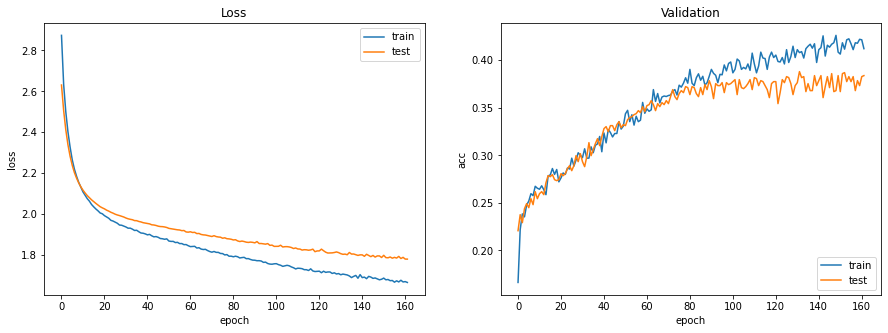

In [22]:
plot_loss_acc(history)
# Evaluamos contra test
score = model.evaluate(X_test_wn, y_test_wn, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

### **1.2 MFCC + _DATA AUGMENTATION_ CON RUIDO BLANCO Y DESPLAZAMIENTO**

In [23]:
feat2_complete_df = concat_features(mfccfeatures_standard_, mfccfeatures_wn_, mfccfeatures_shiftted_)

In [24]:
X_train_2, X_test_2, y_train_2, y_test_2 = dataset_splitted_gender(feat2_complete_df, '')

print("Prueba con {} caracteristicas".format(feat2_complete_df.shape[0]))
print("De las cuales {} son para entrenamiento y {} para test".format(X_train_2.shape[0], X_test_2.shape[0]) )

Prueba con 4320 caracteristicas
De las cuales 2894 son para entrenamiento y 1426 para test


In [25]:

model = model_CNN(X_train_2, y_train_2.shape[1])
model.summary()
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])


# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

history = model.fit(X_train_2, y_train_2, 
                    batch_size=16, 
                    epochs=1000, 
                    # validation_split=0.3
                        validation_data=(X_test_2, y_test_2),
                        callbacks=[rlrp, es])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_3 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_4 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 128)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


181/181 [==============================] - 3s 11ms/step - loss: 2.9013 - accuracy: 0.1558 - val_loss: 2.5608 - val_accuracy: 0.2188
Epoch 2/1000
181/181 [==============================] - 2s 9ms/step - loss: 2.5578 - accuracy: 0.2063 - val_loss: 2.4076 - val_accuracy: 0.2195
Epoch 3/1000
181/181 [==============================] - 1s 8ms/step - loss: 2.3874 - accuracy: 0.2464 - val_loss: 2.3049 - val_accuracy: 0.2391
Epoch 4/1000
181/181 [==============================] - 2s 8ms/step - loss: 2.2820 - accuracy: 0.2507 - val_loss: 2.2358 - val_accuracy: 0.2588
Epoch 5/1000
181/181 [==============================] - 1s 7ms/step - loss: 2.2068 - accuracy: 0.2650 - val_loss: 2.1875 - val_accuracy: 0.2363
Epoch 6/1000
181/181 [==============================] - 2s 8ms/step - loss: 2.1653 - accuracy: 0.2438 - val_loss: 2.1530 - val_accuracy: 0.2391
Epoch 7/1000
181/181 [==============================] - 1s 8ms/step - loss: 2.1255 - accuracy: 0.2567 - val_loss: 2.1240 - val_accuracy: 0.2419
Epoc

12/12 [==============================] - 0s 6ms/step - loss: 1.5766 - accuracy: 0.4502
Loss: 1.5765517950057983 
Accuracy: 45.02103924751282%


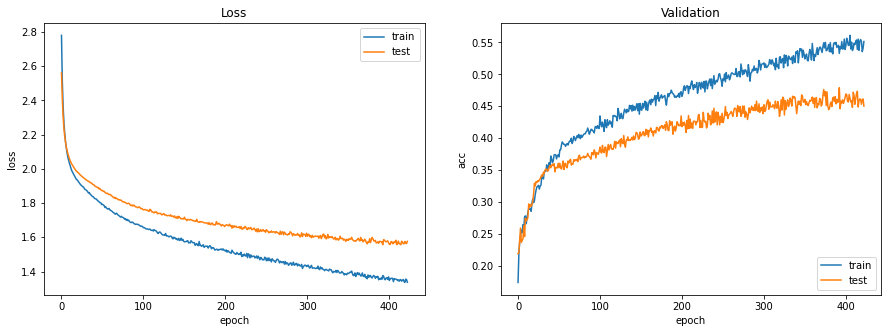

In [26]:
plot_loss_acc(history)
# Evaluamos contra test
score = model.evaluate(X_test_2, y_test_2, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

### **1.3 MFCC + _DATA AUGMENTATION_ CON MODULACION DEL TONO Y DESPLAZAMIENTO**

In [27]:
feat4_complete_df = concat_features(mfccfeatures_standard_, mfccfeatures_shiftted_, mfccfeatures_pitch_)

In [30]:
X_train_4, X_test_4, y_train_4, y_test_4 = dataset_splitted_gender(feat4_complete_df, '')

print("Prueba con {} caracteristicas".format(feat4_complete_df.shape[0]))
print("De las cuales {} son para entrenamiento y {} para test".format(X_train_4.shape[0], X_test_4.shape[0]) )

Prueba con 4320 caracteristicas
De las cuales 2894 son para entrenamiento y 1426 para test


In [31]:
model = model_CNN(X_train_4, y_train_4.shape[1])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_6 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_7 (Activation)    (None, 5, 128)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 128)           

In [32]:
model = model_CNN(X_train_4, y_train_4.shape[1])
model.summary()
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])


# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

history4 = model.fit(X_train_4, y_train_4, 
                    batch_size=16, 
                    epochs=1000, 
                    # validation_split=0.3
                        validation_data=(X_test_4, y_test_4),
                        callbacks=[rlrp, es])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_9 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_10 (Activation)   (None, 5, 128)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 128)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


181/181 [==============================] - 3s 10ms/step - loss: 2.8952 - accuracy: 0.1788 - val_loss: 2.5713 - val_accuracy: 0.2307
Epoch 2/1000
181/181 [==============================] - 1s 8ms/step - loss: 2.5560 - accuracy: 0.2090 - val_loss: 2.4141 - val_accuracy: 0.2539
Epoch 3/1000
181/181 [==============================] - 1s 7ms/step - loss: 2.3972 - accuracy: 0.2360 - val_loss: 2.3092 - val_accuracy: 0.2560
Epoch 4/1000
181/181 [==============================] - 1s 7ms/step - loss: 2.2918 - accuracy: 0.2536 - val_loss: 2.2381 - val_accuracy: 0.2931
Epoch 5/1000
181/181 [==============================] - 1s 7ms/step - loss: 2.2245 - accuracy: 0.2746 - val_loss: 2.1879 - val_accuracy: 0.3001
Epoch 6/1000
181/181 [==============================] - 1s 8ms/step - loss: 2.1880 - accuracy: 0.2614 - val_loss: 2.1504 - val_accuracy: 0.3079
Epoch 7/1000
181/181 [==============================] - 1s 7ms/step - loss: 2.1379 - accuracy: 0.2662 - val_loss: 2.1220 - val_accuracy: 0.2931
Epoc

12/12 [==============================] - 0s 6ms/step - loss: 1.7327 - accuracy: 0.3976
Loss: 1.7327425479888916 
Accuracy: 39.76157009601593%


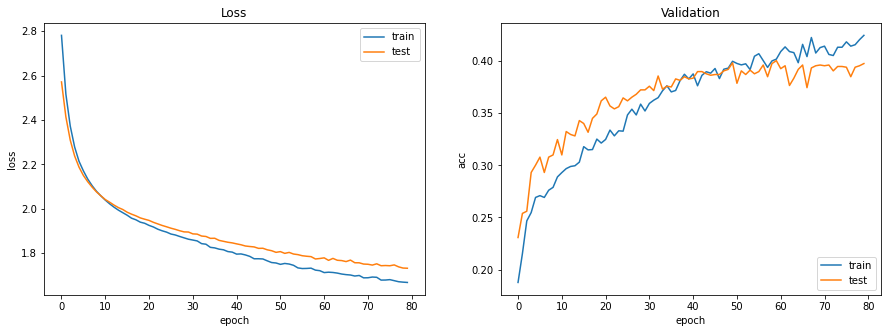

In [33]:
plot_loss_acc(history4)
# Evaluamos contra test
score = model.evaluate(X_test_4, y_test_4, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

### **1.4 MFCC + _DATA AUGMENTATION_ CON RUIDO BLANCO, MODULACION DEL TONO Y DESPLAZAMIENTO**

In [34]:
feat3_complete_df = concat_features(mfccfeatures_standard_, mfccfeatures_wn_, mfccfeatures_shiftted_, mfccfeatures_pitch_)

In [35]:
X_train_3, X_test_3, y_train_3, y_test_3 = dataset_splitted_gender(feat3_complete_df, '')

print("Prueba con {} caracteristicas".format(feat3_complete_df.shape[0]))
print("De las cuales {} son para entrenamiento y {} para test".format(X_train_3.shape[0], X_test_3.shape[0]) )

Prueba con 5760 caracteristicas
De las cuales 3859 son para entrenamiento y 1901 para test


In [36]:
model = model_CNN(X_train_3, y_train_3.shape[1])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 40, 128)           768       
_________________________________________________________________
activation_12 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
activation_13 (Activation)   (None, 5, 128)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 128)           

In [37]:
model = model_CNN(X_train_3, y_train_3.shape[1])
model.summary()
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])


# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

history3 = model.fit(X_train_3, y_train_3, 
                    batch_size=16, 
                    epochs=1000, 
                    # validation_split=0.3
                        validation_data=(X_test_3, y_test_3),
                        callbacks=[rlrp, es])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 40, 128)           768       
_________________________________________________________________
activation_15 (Activation)   (None, 40, 128)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 5, 128)            82048     
_________________________________________________________________
activation_16 (Activation)   (None, 5, 128)            0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 5, 128)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


242/242 [==============================] - 4s 9ms/step - loss: 2.8195 - accuracy: 0.1759 - val_loss: 2.5022 - val_accuracy: 0.2209
Epoch 2/1000
242/242 [==============================] - 2s 7ms/step - loss: 2.4929 - accuracy: 0.2129 - val_loss: 2.3473 - val_accuracy: 0.2199
Epoch 3/1000
242/242 [==============================] - 2s 8ms/step - loss: 2.3419 - accuracy: 0.2184 - val_loss: 2.2509 - val_accuracy: 0.2472
Epoch 4/1000
242/242 [==============================] - 2s 7ms/step - loss: 2.2331 - accuracy: 0.2659 - val_loss: 2.1883 - val_accuracy: 0.2704
Epoch 5/1000
242/242 [==============================] - 2s 7ms/step - loss: 2.1766 - accuracy: 0.2588 - val_loss: 2.1441 - val_accuracy: 0.2751
Epoch 6/1000
242/242 [==============================] - 2s 7ms/step - loss: 2.1237 - accuracy: 0.2689 - val_loss: 2.1116 - val_accuracy: 0.2767
Epoch 7/1000
242/242 [==============================] - 2s 7ms/step - loss: 2.0981 - accuracy: 0.2573 - val_loss: 2.0858 - val_accuracy: 0.2741
Epoch

15/15 [==============================] - 0s 6ms/step - loss: 1.6816 - accuracy: 0.4003
Loss: 1.6816027164459229 
Accuracy: 40.03156125545502%


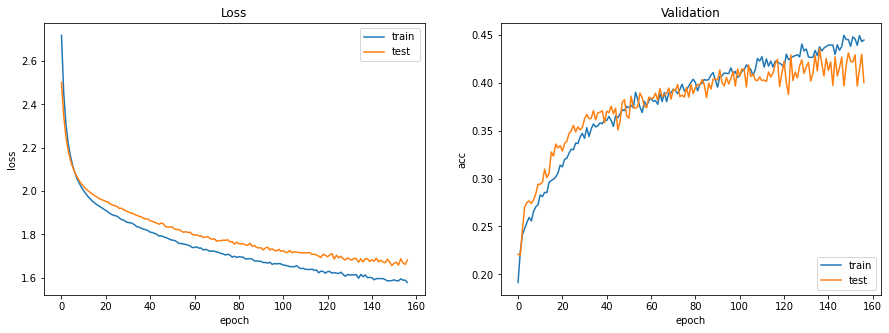

In [38]:
plot_loss_acc(history3)
# Evaluamos contra test
score = model.evaluate(X_test_3, y_test_3, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

## **2. PRUEBAS CON MFCC & MEL**

In [39]:
# Se leen las características MEL (aplicando data augmentation) de los archivos 
features_path = GPATH + LPATH_DATA + '/features/'
if not os.path.exists(features_path + 'featuresMEL_standard_RAVDESS.pkl' and 
                      features_path + 'featuresMEL_wn_RAVDESS.pkl' and 
                      features_path +'featuresMEL_shiftted_RAVDESS.pk' and 
                      features_path + 'featuresMEL_pitch_RAVDESS.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMEL = MEL(EnglishSpeech_df, features_path)
  melfeatures_standard_, melfeatures_wn_, melfeatures_shiftted_, melfeatures_pitch_ = featuresMEL.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMEL_standard_RAVDESS.pkl', 'rb') as f:
    melfeatures_standard_ = pickle.load(f)

  with open(features_path + 'featuresMEL_wn_RAVDESS.pkl', 'rb') as f:
    melfeatures_wn_ = pickle.load(f)

  with open(features_path + 'featuresMEL_shiftted_RAVDESS.pkl', 'rb') as f:
    melfeatures_shiftted_ = pickle.load(f)

  with open(features_path + 'featuresMEL_pitch_RAVDESS.pkl', 'rb') as f:
    melfeatures_pitch_ = pickle.load(f)

### **2.1 MFCC + MEL**

In [40]:
# Concatenamos los dos dataframes de caracteristicas que usaremos en  nuestro entrenamiento
melmfcc_feat_complete_df1 = concat_features(mfccfeatures_standard_, melfeatures_standard_)

In [41]:
X_train_1, X_test_1, y_train_1, y_test_1 = dataset_splitted_gender(melmfcc_feat_complete_df1, '')

print("Prueba con {} caracteristicas".format(melmfcc_feat_complete_df1.shape[0]))
print("De las cuales {} son para entrenamiento y {} para test".format(X_train_1.shape[0], X_test_1.shape[0]) )

Prueba con 2880 caracteristicas
De las cuales 1929 son para entrenamiento y 951 para test


In [42]:
model = model_CNN(X_train_1, y_train_1.shape[1])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 128, 128)          768       
_________________________________________________________________
activation_18 (Activation)   (None, 128, 128)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 16, 128)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16, 128)           82048     
_________________________________________________________________
activation_19 (Activation)   (None, 16, 128)           0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 16, 128)          

In [43]:
opt = keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])

# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

history = model.fit(X_train_1, y_train_1, 
                        batch_size=16, 
                        epochs=1000, 
                        validation_data=(X_test_1, y_test_1),
                        callbacks=[rlrp, es])

Epoch 1/1000
121/121 [==============================] - 4s 18ms/step - loss: nan - accuracy: 0.1338 - val_loss: nan - val_accuracy: 0.1335
Epoch 2/1000
121/121 [==============================] - 2s 14ms/step - loss: nan - accuracy: 0.1240 - val_loss: nan - val_accuracy: 0.1335
Epoch 3/1000
121/121 [==============================] - 2s 15ms/step - loss: nan - accuracy: 0.1204 - val_loss: nan - val_accuracy: 0.1335
Epoch 4/1000
121/121 [==============================] - 2s 15ms/step - loss: nan - accuracy: 0.1326 - val_loss: nan - val_accuracy: 0.1335
Epoch 5/1000
121/121 [==============================] - 2s 14ms/step - loss: nan - accuracy: 0.1228 - val_loss: nan - val_accuracy: 0.1335
Epoch 6/1000
121/121 [==============================] - 2s 15ms/step - loss: nan - accuracy: 0.1391 - val_loss: nan - val_accuracy: 0.1335
Epoch 7/1000
121/121 [==============================] - 2s 14ms/step - loss: nan - accuracy: 0.1293 - val_loss: nan - val_accuracy: 0.1335
Epoch 8/1000
121/121 [=====

### **2.2 MFCC + MEL + _DA_: RUIDO BLANCO**

In [44]:
melmfcc_feat_complete_df2 = concat_features( melfeatures_standard_, melfeatures_wn_)

In [45]:
X_train_2, X_test_2, y_train_2, y_test_2 = dataset_splitted_gender(melmfcc_feat_complete_df2, '')

print("Prueba con {} caracteristicas".format(melmfcc_feat_complete_df2.shape[0]))
print("De las cuales {} son para entrenamiento y {} para test".format(X_train_2.shape[0], X_test_2.shape[0]) )

Prueba con 2880 caracteristicas
De las cuales 1929 son para entrenamiento y 951 para test


In [46]:
model = model_CNN2(X_train_2, y_train_2.shape[1])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 128, 16)           96        
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 128, 32)           2592      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 128, 64)           10304     
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 128, 128)          41088     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)              

In [47]:
opt = keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])

# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

history = model.fit(X_train_2, y_train_2, 
                        batch_size=128, 
                        epochs=1000, 
                        validation_data=(X_test_2, y_test_2),
                        callbacks=[rlrp, es])

Epoch 1/1000
16/16 [==============================] - 5s 209ms/step - loss: 2.0264 - accuracy: 0.1822 - val_loss: 1.9646 - val_accuracy: 0.2387
Epoch 2/1000
16/16 [==============================] - 3s 180ms/step - loss: 1.9386 - accuracy: 0.2468 - val_loss: 1.9161 - val_accuracy: 0.2450
Epoch 3/1000
16/16 [==============================] - 3s 182ms/step - loss: 1.8794 - accuracy: 0.2550 - val_loss: 1.8808 - val_accuracy: 0.2545
Epoch 4/1000
16/16 [==============================] - 3s 180ms/step - loss: 1.8394 - accuracy: 0.2784 - val_loss: 1.8627 - val_accuracy: 0.2839
Epoch 5/1000
16/16 [==============================] - 3s 181ms/step - loss: 1.8353 - accuracy: 0.2973 - val_loss: 1.8306 - val_accuracy: 0.2608
Epoch 6/1000
16/16 [==============================] - 3s 182ms/step - loss: 1.8132 - accuracy: 0.2805 - val_loss: 1.8178 - val_accuracy: 0.2681
Epoch 7/1000
16/16 [==============================] - 3s 180ms/step - loss: 1.7691 - accuracy: 0.2968 - val_loss: 1.7983 - val_accuracy:

8/8 [==============================] - 0s 35ms/step - loss: 1.4549 - accuracy: 0.5615
Loss: 1.4548847675323486 
Accuracy: 56.15141987800598%


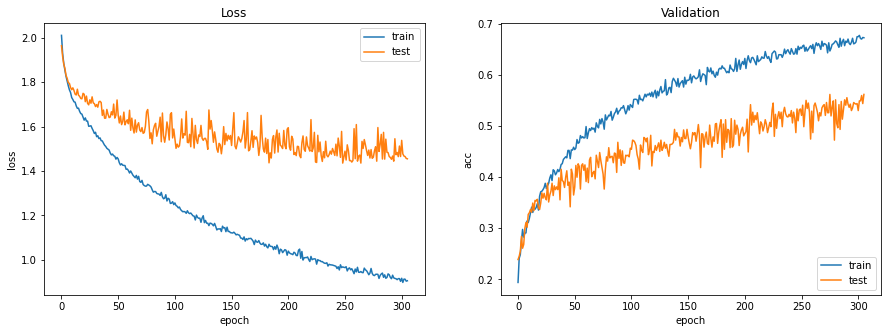

In [48]:
plot_loss_acc(history)
# Evaluamos contra test
score = model.evaluate(X_test_2, y_test_2, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

### **2.3 MFCC + MEL + _DA_: RUIDO BLANCO Y DESPLAZAMIENTO**

In [49]:
melmfcc_feat_complete_df3 = concat_features( melfeatures_standard_, melfeatures_wn_, melfeatures_pitch_) #(mfccfeatures_standard_, mfccfeatures_wn_, mfccfeatures_shiftted_, mfccfeatures_pitch_)

In [50]:
X_train_3, X_test_3, y_train_3, y_test_3 = dataset_splitted_gender(melmfcc_feat_complete_df3, '')

print("Prueba con {} caracteristicas".format(melmfcc_feat_complete_df3.shape[0]))
print("De las cuales {} son para entrenamiento y {} para test".format(X_train_3.shape[0], X_test_3.shape[0]) )

Prueba con 4320 caracteristicas
De las cuales 2894 son para entrenamiento y 1426 para test


In [51]:
model = model_CNN(X_train_3, y_train_3.shape[1])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 128, 128)          768       
_________________________________________________________________
activation_21 (Activation)   (None, 128, 128)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 128, 128)          0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 16, 128)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 16, 128)           82048     
_________________________________________________________________
activation_22 (Activation)   (None, 16, 128)           0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 128)          

In [52]:
opt = keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer = opt, 
              metrics=['accuracy'])

# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

history = model.fit(X_train_3, y_train_3, 
                        batch_size=128, 
                        epochs=1000, 
                        validation_data=(X_test_3, y_test_3),
                        callbacks=[rlrp, es])

Epoch 1/1000
23/23 [==============================] - 4s 105ms/step - loss: 5.9244 - accuracy: 0.1674 - val_loss: 5.9526 - val_accuracy: 0.2188
Epoch 2/1000
23/23 [==============================] - 2s 88ms/step - loss: 5.9629 - accuracy: 0.1922 - val_loss: 5.6571 - val_accuracy: 0.2426
Epoch 3/1000
23/23 [==============================] - 2s 86ms/step - loss: 4.9789 - accuracy: 0.2127 - val_loss: 5.4118 - val_accuracy: 0.2532
Epoch 4/1000
23/23 [==============================] - 2s 85ms/step - loss: 4.7830 - accuracy: 0.1931 - val_loss: 5.2207 - val_accuracy: 0.2391
Epoch 5/1000
23/23 [==============================] - 2s 86ms/step - loss: 4.7610 - accuracy: 0.2324 - val_loss: 5.0395 - val_accuracy: 0.2426
Epoch 6/1000
23/23 [==============================] - 2s 85ms/step - loss: 4.3857 - accuracy: 0.2187 - val_loss: 4.8786 - val_accuracy: 0.2370
Epoch 7/1000
23/23 [==============================] - 2s 84ms/step - loss: 4.3773 - accuracy: 0.2321 - val_loss: 4.7255 - val_accuracy: 0.245

12/12 [==============================] - 0s 16ms/step - loss: 2.1159 - accuracy: 0.2574
Loss: 2.1158626079559326 
Accuracy: 25.736325979232788%


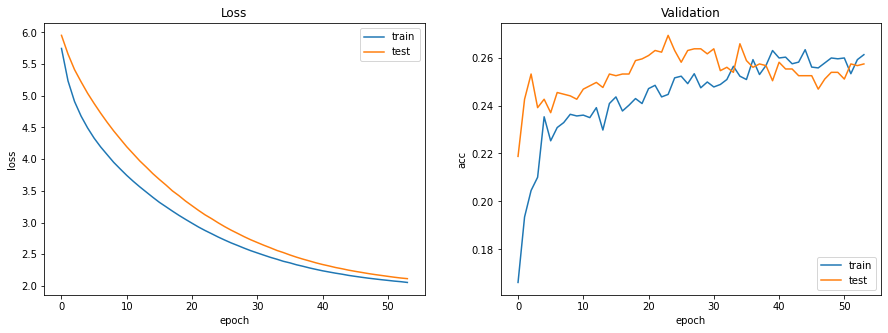

In [53]:
plot_loss_acc(history)
# Evaluamos contra test
score = model.evaluate(X_test_3, y_test_3, batch_size=128)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

### **2.4 MFCC + MEL + _DA_: RUIDO BLANC, DESPLAZAMIENTO Y MODULACIÓN**

In [54]:
feat3_complete_df = concat_features(mfccfeatures_standard_, mfccfeatures_wn_, mfccfeatures_shiftted_, mfccfeatures_pitch_)